In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import io
from PIL import Image
import numpy as np
import os
import random

In [38]:

def extract_categories_and_create_palette(tfrecord_directory):
    """Extracts category names and creates a color palette from TFRecord files."""

    tfrecord_files = sorted([os.path.join(tfrecord_directory, f) for f in os.listdir(tfrecord_directory) if f.endswith('.tfrecord')])

    if not tfrecord_files:
        print(f"No TFRecord files found in directory: {tfrecord_directory}")
        return None, None

    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)

    def _parse_function(example_proto):
        feature_description = {
            'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        }
        return tf.io.parse_single_example(example_proto, feature_description)

    parsed_dataset = raw_dataset.map(_parse_function)

    category_ids = set()
    for features in parsed_dataset:
        labels = features['image/object/class/label'].values.numpy()
        category_ids.update(labels)

    category_names = {cat_id: f'Category {cat_id}' for cat_id in sorted(category_ids)}
    color_palette = {}
    for cat_id in sorted(category_ids):
        color_palette[cat_id] = (random.random(), random.random(), random.random())

    return category_names, color_palette

def visualize_tfrecord_images(tfrecord_directory, category_names, color_palette, num_images=5):
    """Visualizes images with bounding boxes, masks, and category names using a provided color palette."""

    tfrecord_files = sorted([os.path.join(tfrecord_directory, f) for f in os.listdir(tfrecord_directory) if f.endswith('.tfrecord')])

    if not tfrecord_files:
        print(f"No TFRecord files found in directory: {tfrecord_directory}")
        return

    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)

    def _parse_function(example_proto):
        feature_description = {
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
            'image/object/mask': tf.io.VarLenFeature(tf.string),
            'image/object/class/label': tf.io.VarLenFeature(tf.int64),
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
        }
        return tf.io.parse_single_example(example_proto, feature_description)

    parsed_dataset = raw_dataset.map(_parse_function)

    image_count = 0
    for features in parsed_dataset:
        if image_count >= num_images:
            break

        image_raw = features['image/encoded'].numpy()
        image = Image.open(io.BytesIO(image_raw))

        fig, ax = plt.subplots(1)
        ax.imshow(image)

        xmin = features['image/object/bbox/xmin'].values.numpy()
        ymin = features['image/object/bbox/ymin'].values.numpy()
        xmax = features['image/object/bbox/xmax'].values.numpy()
        ymax = features['image/object/bbox/ymax'].values.numpy()
        labels = features['image/object/class/label'].values.numpy()
        mask_raw = features['image/object/mask'].values.numpy()
        height = features['image/height'].numpy()
        width = features['image/width'].numpy()

        for i in range(len(xmin)):
            color = color_palette[labels[i]]

            rect = patches.Rectangle((xmin[i] * image.width, ymin[i] * image.height),
                                      (xmax[i] - xmin[i]) * image.width,
                                      (ymax[i] - ymin[i]) * image.height,
                                      linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            x_text = xmin[i] * image.width + 5
            y_text = ymin[i] * image.height + 5

            ax.text(x_text, y_text, category_names[labels[i]], color=color, fontsize=8, backgroundcolor='black', verticalalignment='top', horizontalalignment='left')

            if len(mask_raw) > 0:
                mask_bytes = mask_raw[i]
                mask_tensor = tf.convert_to_tensor(mask_bytes)
                mask = tf.image.decode_png(mask_tensor, channels=1).numpy().squeeze()
                ax.imshow(mask, alpha=0.3, cmap=plt.cm.colors.ListedColormap([(0, 0, 0, 0), color]))

        plt.show()
        image_count += 1



2025-03-10 20:47:58.315879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


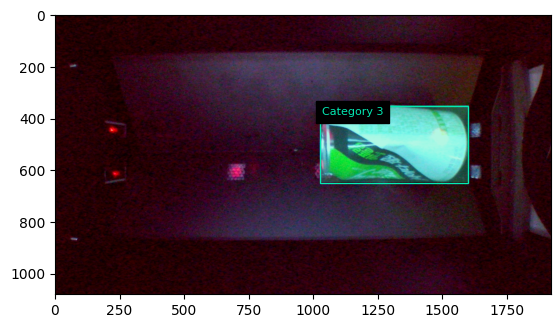

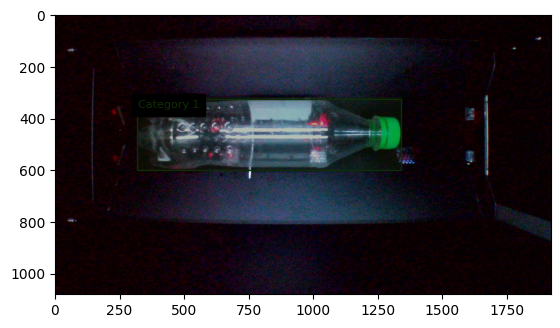

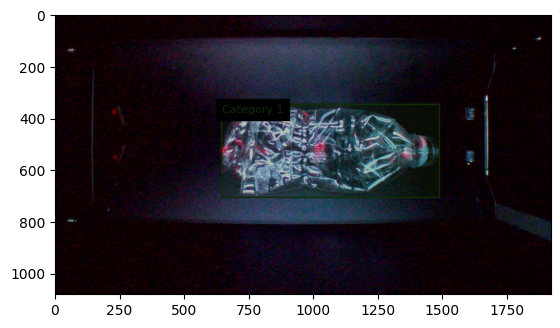

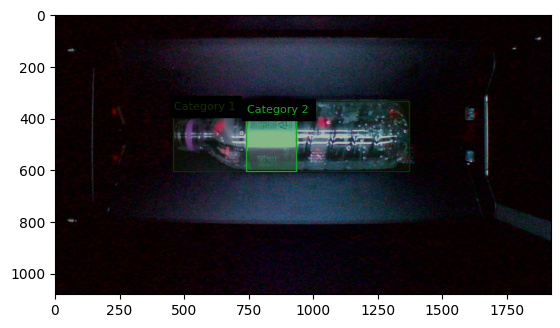

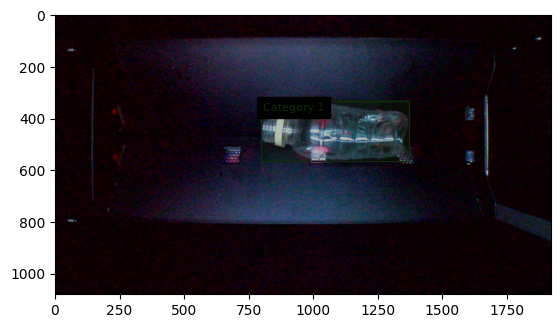

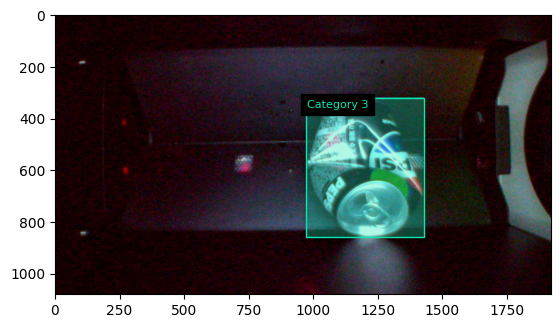

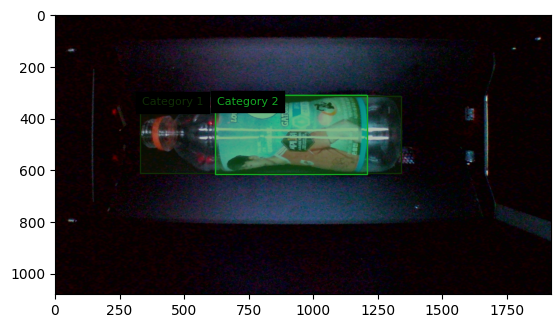

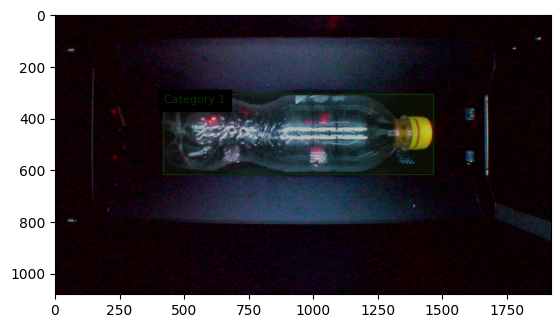

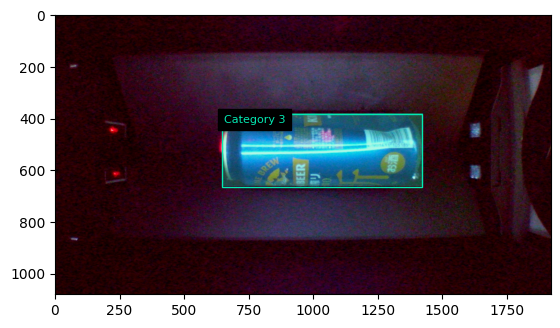

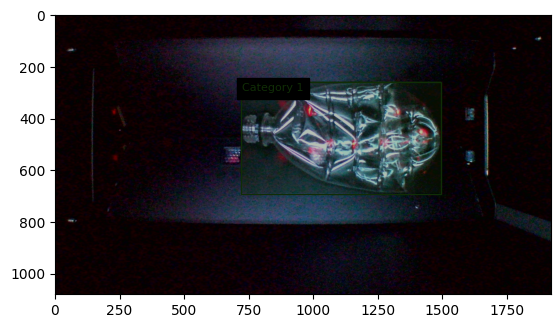

In [ ]:
tfrecord_directory = '.././rc40tfrecords/val' # TFrecords directory files

category_names, color_palette = extract_categories_and_create_palette(tfrecord_directory)

if category_names and color_palette:
    visualize_tfrecord_images(tfrecord_directory, category_names, color_palette, 10)